# Урок 3. Построение надежных схем валидации решения, оптимизация целевых метрик.

Домашнее задание

##### Импорт библиотек

In [2]:
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
# import catboost as cb
# import lightgbm as lgb

import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter("ignore")
# warnings.filterwarnings('ignore')

## Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы/минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - `IsFraud`. Рекомендуется использовать модели градиетного бустинга, реализация любая, гипепараметры любые.

**NB!** выборка `assignment_2_test.csv` - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!

Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод fit /train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.

In [4]:
train = pd.read_csv('./data/assignment2_data/assignment_2_train.csv')
leaderboard = pd.read_csv('./data/assignment2_data/assignment_2_test.csv')
target = 'isFraud'

print("train.shape = {} rows, {} cols".format(*train.shape))
print("leaderboard.shape = {} rows, {} cols".format(*leaderboard.shape))

train.shape = 180000 rows, 394 cols
leaderboard.shape = 100001 rows, 394 cols


In [5]:
train.head(n=3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Задание 1. Сделать **Hold-Out** валидацию
Сделать Hold-Out валидацию с разбиением, размер которого будет адекватным, по вашему мнению. Разбиение проводить по id-транзакции (`TransactionID`), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [6]:
numerical_features = train \
    .select_dtypes(include=[np.number]) \
    .drop(target, axis=1) \
    .columns \
    .tolist()

In [7]:
X, y = train[numerical_features].fillna(0), train[target]
X_lb, y_lb = leaderboard[numerical_features].fillna(0), leaderboard[target]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)

In [9]:
params = {
    "booster": "gbtree", "objective": "binary:logistic",
    "eval_metric": "auc", "learning_rate": 0.1, "n_estimators": 1000,
    "reg_lambda": 100, "max_depth": 4, "gamma": 10, "nthread": 6, "seed": 27
}

In [10]:
model_xgb_numeric = xgb.XGBClassifier(**params)
model_xgb_numeric.fit(X=x_train, y=y_train,
                      eval_set=[(x_train, y_train), (x_test, y_test)],
                      early_stopping_rounds=30, eval_metric="auc", verbose=20)

[0]	validation_0-auc:0.59781	validation_1-auc:0.61482
[20]	validation_0-auc:0.81385	validation_1-auc:0.82154
[40]	validation_0-auc:0.87183	validation_1-auc:0.84969
[60]	validation_0-auc:0.88592	validation_1-auc:0.86278
[80]	validation_0-auc:0.89107	validation_1-auc:0.86816
[100]	validation_0-auc:0.89542	validation_1-auc:0.86979
[120]	validation_0-auc:0.89897	validation_1-auc:0.87192
[140]	validation_0-auc:0.90179	validation_1-auc:0.87399
[160]	validation_0-auc:0.90252	validation_1-auc:0.87447
[180]	validation_0-auc:0.90291	validation_1-auc:0.87500
[197]	validation_0-auc:0.90291	validation_1-auc:0.87500


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [11]:
train_score = roc_auc_score(y_train, model_xgb_numeric.predict_proba(x_train)[:, 1])
test_score = roc_auc_score(y_test, model_xgb_numeric.predict_proba(x_test)[:, 1])
LB_score = roc_auc_score(y_lb, model_xgb_numeric.predict_proba(X_lb)[:, 1])

Hold_Outpd_2 = pd.DataFrame(data=[{'Train-score': train_score,
                                   'Valid-score': '-',
                                   'Test-score': test_score,
                                   'LB-score': LB_score}], index=['2-Hold-Out'])
Hold_Outpd_2

,Train-score,Valid-score,Test-score,LB-score
2-Hold-Out,0.902878,-,0.875026,0.862459


#### Вывод: ____

### Задание 2. Сделать **Hold-Out** валидацию с разбиением на 3 выборки.
Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (`TransactionID`), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.50, shuffle=False, random_state=1)

In [13]:
model_xgb_numeric = xgb.XGBClassifier(**params)
model_xgb_numeric.fit(X=x_train, y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=30, eval_metric="auc", verbose=20)

[0]	validation_0-auc:0.59781	validation_1-auc:0.60969
[20]	validation_0-auc:0.81385	validation_1-auc:0.82929
[40]	validation_0-auc:0.87183	validation_1-auc:0.85479
[60]	validation_0-auc:0.88592	validation_1-auc:0.86884
[80]	validation_0-auc:0.89107	validation_1-auc:0.87467
[100]	validation_0-auc:0.89542	validation_1-auc:0.87665
[120]	validation_0-auc:0.89897	validation_1-auc:0.87870
[140]	validation_0-auc:0.90179	validation_1-auc:0.88095
[160]	validation_0-auc:0.90252	validation_1-auc:0.88146
[180]	validation_0-auc:0.90291	validation_1-auc:0.88185
[196]	validation_0-auc:0.90291	validation_1-auc:0.88185


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [14]:
train_score = roc_auc_score(y_train, model_xgb_numeric.predict_proba(x_train)[:, 1])
valid_score = roc_auc_score(y_valid, model_xgb_numeric.predict_proba(x_valid)[:, 1])
test_score = roc_auc_score(y_test, model_xgb_numeric.predict_proba(x_test)[:, 1])
LB_score = roc_auc_score(y_lb, model_xgb_numeric.predict_proba(X_lb)[:, 1])

Hold_Outpd_3 = pd.DataFrame(data=[{'Train-score': train_score,
                                   'Valid-score': valid_score,
                                   'Test-score': test_score,
                                   'LB-score': LB_score}], index=['3-Hold-Out'])
Hold_Outpd_2.append(Hold_Outpd_3)

,Train-score,Valid-score,Test-score,LB-score
2-Hold-Out,0.902878,-,0.875026,0.862459
3-Hold-Out,0.902878,0.881866,0.869149,0.862459


#### Вывод: Значение меткрики на тесте снизилось, но стало более схоже с метрикой на лидерборде

### Задание 3. Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [15]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.
    """
    bootstrap_idx = np.random.randint(low=0, high=len(data), size=(n_samples, len(data)))
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array, y_pred: np.array, 
                             metric: callable, n_samples: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.
    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true, n_samples=n_samples)

    for idx in bootstrap_idx:
        y_true_bootstrap, y_pred_bootstrap = y_true[idx], y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float, float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.
    """
    left_bound = np.percentile(scores, ((1 - conf_interval) / 2) * 100)
    right_bound = np.percentile(scores, (conf_interval + ((1 - conf_interval) / 2)) * 100)

    return left_bound, right_bound

In [17]:
np.random.seed(3)
print('confidence_interval - valid', 
calculate_confidence_interval(scores=create_bootstrap_metrics(y_true=y_valid, 
                                                              y_pred=model_xgb_numeric.predict(x_valid), 
                                                              metric=roc_auc_score)))
print('confidence_interval -  test', 
calculate_confidence_interval(scores=create_bootstrap_metrics(y_true=y_test,
                                                              y_pred=model_xgb_numeric.predict(x_test), 
                                                              metric=roc_auc_score)))
print('confidence_interval -    LB', 
calculate_confidence_interval(scores=create_bootstrap_metrics(y_true=y_lb,
                                                              y_pred=model_xgb_numeric.predict(X_lb), 
                                                              metric=roc_auc_score)))

confidence_interval - valid (0.6673925569764337, 0.7015140981851853)
confidence_interval -  test (0.6183331884970227, 0.6470257079965894)
confidence_interval -    LB (0.6185575027442716, 0.6321603465443131)


#### Вывод: что-то совсем не попадаю в доверит интервал

### Задание 4. Выполнить **Adversarial Validation**, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [9]:
# x_adv = pd.concat([X, X_lb], axis=0)
# y_adv = np.hstack((np.zeros(X.shape[0]), np.ones(X_lb.shape[0])))
# assert x_adv.shape[0] == y_adv.shape[0]

In [ ]:
# model_xgb_numeric = xgb.XGBClassifier(**params)
# model_xgb_numeric.fit(X=x_adv, y=y_adv,
#                       eval_set=[(x_train, y_train), (x_test, y_test)],
#                       early_stopping_rounds=30, eval_metric="auc", verbose=20)

### Задание 5. Сделать **KFold / StratifiedKFold** валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных. Оценить качество на ЛБ, сделать выводы.

In [70]:
model_xgb_numeric = xgb.XGBClassifier(**params)

In [ ]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy, groups=None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
    groups: array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into train/test set.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    results = []
    
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y, groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        print(f"Fold: {fold_number+1}", end='| ')
        estimators.append(estimator)
        results.append([fold_number+1,
                        len(train_idx),
                        len(valid_idx),
                        round(fold_train_scores[fold_number], 4),
                        round(fold_valid_scores[fold_number], 4)])
        
    oof_score = metric(y, oof_predictions)

    display(pd.DataFrame(results, columns=['Fold', 'train-observations', 'valid-observations',
                                           'train-score', 'valid-score']))

    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [ ]:
cv_strategy = KFold(n_splits=5, random_state=1)
estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = \
    make_cross_validation(X=X, y=y, 
                          estimator=model_xgb_numeric, 
                          metric=r2_score, 
                          cv_strategy=cv_strategy)

In [ ]:
# Очень долго, как как будно не хыватает мощности

### Задание 6 (опциональное). Сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [84]:
# ---

### Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [48]:
train.iloc[:3, :17]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN


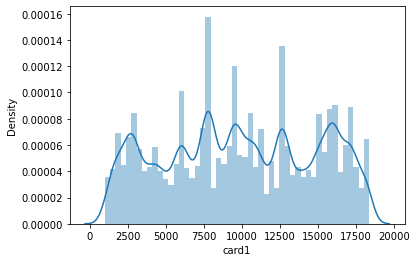

In [69]:
sns.distplot(train['card1']);

In [59]:
for i in col_:
    if train[i].nunique() < 10:
        print(i, train[i].unique())

isFraud [0 1]
ProductCD ['W' 'H' 'C' 'S' 'R']
card4 ['discover' 'mastercard' 'visa' 'american express' nan]
card6 ['credit' 'debit' nan 'debit or credit' 'charge card']


In [85]:
# Очень долго, как как будно не хыватает мощности

In [ ]:
from sklearn.model_selection import GroupKFold

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = \
    make_cross_validation(X=X, y=y, estimator=model_xgb_numeric, metric=r2_score, 
                          cv_strategy=GroupKFold(n_splits=5),
                          groups=X['card1'])